In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

import sys
sys.path.insert(0, '../..')

import quan_utils
import pulp

In [2]:
prob_df = pd.read_csv('../../data/data.csv', index_col=0)
capacity_df = prob_df['Real'].value_counts()

NUM_SAMPLES = 5
BUDGETS = [10, 10, 10, 10, 10]
TYPES = ['ES', 'PSH', 'TH', 'RRH', 'PREV']
COST_TYPES = ['linear', 'linear', 'linear', 'linear', 'linear']


def capacity_cost(capacity_increases):
    running_total = 0
    
    for type_index, increase in enumerate(capacity_increases):
        if COST_TYPES[type_index] == 'linear':
            running_total += increase
        elif COST_TYPES[type_index] == 'log':
            running_total += np.log(increase + 1)
        elif COST_TYPES[type_index] == 'quadratic':
            running_total += increase ** 2
    
    return running_total


# All objective functions
def obj_f(x):
    fairness_constraint = x[0]
    
    helper = quan_utils.AssignmentHelper()
    
    new_capacity_df = capacity_df.copy()
    for type_index, type_ in enumerate(TYPES):
        new_capacity_df.loc[type_index + 1] += x[type_index + 1]
    
    helper.update_constraints(
        fairness_constraint=fairness_constraint,
        capacity_df=new_capacity_df
    )
    # print(new_capacity_df)
    
    sol_df = helper.ip_solve()
    real_n_reentries, bart_n_reentries, sol_n_reentries = helper.compare_reentry(sol_df, verbose=False)
    prob_compare_df = helper.compare_prob(sol_df)
    
    # return np.hstack((
    #     [[- (real_n_reentries - sol_n_reentries) / real_n_reentries * 100]],
    #     [[prob_compare_df[prob_compare_df['Diff'] > 0]['Diff'].mean()]],
    #     capacity_cost(x[1 :])
    # ))
    
    return (
        sol_n_reentries,
        prob_compare_df['Diff'].max(),
        prob_compare_df[prob_compare_df['Diff'] > 0]['Diff'].mean(),
        prob_compare_df[prob_compare_df['Diff'] > 0]['Diff'].quantile(0.75),
        prob_compare_df['Diff'].max() - prob_compare_df['Diff'].min(),
        capacity_cost(x[1:])
    )

# Changing capacities in `PSH` and `PREV`

In [26]:
increase_budget = 5
# psh_search_space = [3000, 4000, 5000, 6000, 7000]
# prev_search_space = [1000, 1500, 2000, 2500, 3000]
# psh_search_space = [0]
# prev_search_space = [20, 40, 60, 80, 100]

# xs = [[[0.05, 0, psh_val, 0, 0, prev_val] 
#        for prev_val in prev_search_space]
#       for psh_val in psh_search_space]

th_search_space = [750, 1000, 1250, 1500, 1750]
rrh_search_space = [500, 1000, 1500, 2000, 2500]

xs = [[[0.05, 0, 0, th_val, rrh_val, 0]
        for th_val in th_search_space]
       for rrh_val in rrh_search_space]

xs

[[[0.05, 0, 0, 1000, 700, 0],
  [0.05, 0, 0, 1250, 700, 0],
  [0.05, 0, 0, 1500, 700, 0],
  [0.05, 0, 0, 1750, 700, 0],
  [0.05, 0, 0, 2000, 700, 0]],
 [[0.05, 0, 0, 1000, 800, 0],
  [0.05, 0, 0, 1250, 800, 0],
  [0.05, 0, 0, 1500, 800, 0],
  [0.05, 0, 0, 1750, 800, 0],
  [0.05, 0, 0, 2000, 800, 0]],
 [[0.05, 0, 0, 1000, 900, 0],
  [0.05, 0, 0, 1250, 900, 0],
  [0.05, 0, 0, 1500, 900, 0],
  [0.05, 0, 0, 1750, 900, 0],
  [0.05, 0, 0, 2000, 900, 0]],
 [[0.05, 0, 0, 1000, 1000, 0],
  [0.05, 0, 0, 1250, 1000, 0],
  [0.05, 0, 0, 1500, 1000, 0],
  [0.05, 0, 0, 1750, 1000, 0],
  [0.05, 0, 0, 2000, 1000, 0]],
 [[0.05, 0, 0, 1000, 1100, 0],
  [0.05, 0, 0, 1250, 1100, 0],
  [0.05, 0, 0, 1500, 1100, 0],
  [0.05, 0, 0, 1750, 1100, 0],
  [0.05, 0, 0, 2000, 1100, 0]]]

In [27]:
percentage_reductions = []
max_prob_diff = []
avg_pos_prob_increase = []
thirdq_pos_prob_increase = []
range_prob_diff = []
capacity_costs = []

for i in range(increase_budget):
    print(i)
    
    percentage_reductions.append([])
    max_prob_diff.append([])
    avg_pos_prob_increase.append([])
    thirdq_pos_prob_increase.append([])
    range_prob_diff.append([])
    capacity_costs.append([])
    
    for j in range(increase_budget):
        result = obj_f(xs[i][j])
        
        percentage_reductions[-1].append(result[0])
        max_prob_diff[-1].append(result[1])
        avg_pos_prob_increase[-1].append(result[2])
        thirdq_pos_prob_increase[-1].append(result[3])
        range_prob_diff[-1].append(result[4])
        capacity_costs[-1].append(result[5])

0
1
2
3
4


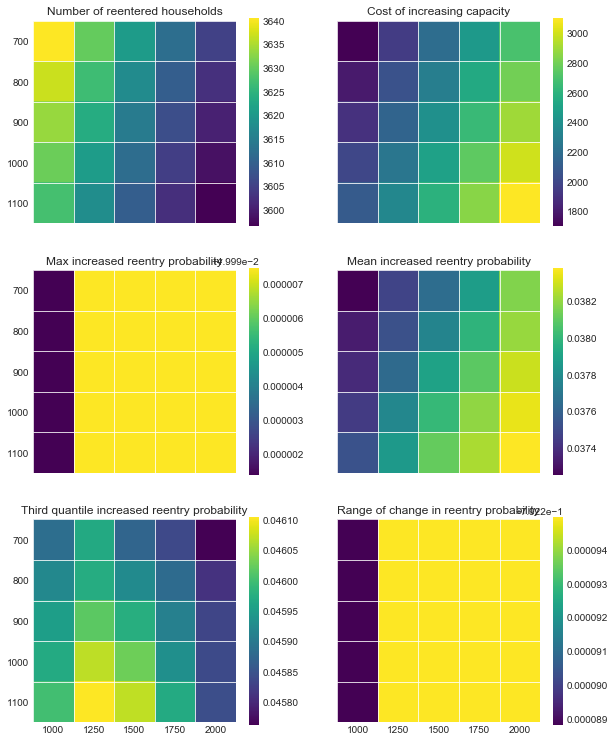

In [28]:
xlabels = th_search_space
ylabels = rrh_search_space

f, ax = plt.subplots(3, 2, figsize=(10, 13), sharex=True, sharey=True)

# Utility and cost in the first row
m = ax[0][0].imshow(percentage_reductions, cmap='viridis')
f.colorbar(m, ax=ax[0][0])
ax[0][0].set_title('Number of reentered households')

m = ax[0][1].imshow(capacity_costs, cmap='viridis')
f.colorbar(m, ax=ax[0][1])
ax[0][1].set_title('Cost of increasing capacity')

# Second and third rows contain fairness metrics
m = ax[1][0].imshow(max_prob_diff, cmap='viridis')
f.colorbar(m, ax=ax[1][0])
ax[1][0].set_title('Max increased reentry probability')

m = ax[1][1].imshow(avg_pos_prob_increase, cmap='viridis')
f.colorbar(m, ax=ax[1][1])
ax[1][1].set_title('Mean increased reentry probability')

m = ax[2][0].imshow(thirdq_pos_prob_increase, cmap='viridis')
f.colorbar(m, ax=ax[2][0])
ax[2][0].set_title('Third quantile increased reentry probability')

m = ax[2][1].imshow(range_prob_diff, cmap='viridis')
f.colorbar(m, ax=ax[2][1])
ax[2][1].set_title('Range of change in reentry probability')

ax[0][0].set_yticks([i for i in range(increase_budget)])
ax[0][0].set_yticklabels(ylabels)
ax[1][0].set_yticks([i for i in range(increase_budget)])
ax[1][0].set_yticklabels(ylabels)
ax[2][0].set_yticks([i for i in range(increase_budget)])
ax[2][0].set_yticklabels(ylabels)

ax[2][0].set_xticks([i for i in range(increase_budget)])
ax[2][0].set_xticklabels(xlabels)
ax[2][1].set_xticks([i for i in range(increase_budget)])
ax[2][1].set_xticklabels(xlabels)

for row in range(3):
    for col in range(2):
        ax[row][col].set_xticks(
            [i - 0.5 for i in range(increase_budget + 1)], 
            minor=True
        )
        ax[row][col].set_yticks(
            [i - 0.5 for i in range(increase_budget + 1)], 
            minor=True
        )
        ax[row][col].grid(b=None)
        ax[row][col].grid(which='minor')

plt.show()

# Changing fairness constraints and capacities in `PREV`

In [12]:
increase_budget = constraint_budget = 5

th_search_space = [0, 500, 1000, 1500, 2000]
fairness_constraint_search_space = [0.02, 0.04, 0.06, 0.08, 0.1]

xs = [[[fairness_constraint, 0, 0, th_val, 0, 0]
        for th_val in th_search_space]
       for fairness_constraint in fairness_constraint_search_space]

xs

[[[0.02, 0, 0, 0, 0, 0],
  [0.02, 0, 0, 500, 0, 0],
  [0.02, 0, 0, 1000, 0, 0],
  [0.02, 0, 0, 1500, 0, 0],
  [0.02, 0, 0, 2000, 0, 0]],
 [[0.04, 0, 0, 0, 0, 0],
  [0.04, 0, 0, 500, 0, 0],
  [0.04, 0, 0, 1000, 0, 0],
  [0.04, 0, 0, 1500, 0, 0],
  [0.04, 0, 0, 2000, 0, 0]],
 [[0.06, 0, 0, 0, 0, 0],
  [0.06, 0, 0, 500, 0, 0],
  [0.06, 0, 0, 1000, 0, 0],
  [0.06, 0, 0, 1500, 0, 0],
  [0.06, 0, 0, 2000, 0, 0]],
 [[0.08, 0, 0, 0, 0, 0],
  [0.08, 0, 0, 500, 0, 0],
  [0.08, 0, 0, 1000, 0, 0],
  [0.08, 0, 0, 1500, 0, 0],
  [0.08, 0, 0, 2000, 0, 0]],
 [[0.1, 0, 0, 0, 0, 0],
  [0.1, 0, 0, 500, 0, 0],
  [0.1, 0, 0, 1000, 0, 0],
  [0.1, 0, 0, 1500, 0, 0],
  [0.1, 0, 0, 2000, 0, 0]]]

In [13]:
percentage_reductions = []
max_prob_diff = []
avg_pos_prob_increase = []
thirdq_pos_prob_increase = []
range_prob_diff = []
capacity_costs = []

for i in range(increase_budget):
    print(i)
    
    percentage_reductions.append([])
    max_prob_diff.append([])
    avg_pos_prob_increase.append([])
    thirdq_pos_prob_increase.append([])
    range_prob_diff.append([])
    capacity_costs.append([])
    
    for j in range(increase_budget):
        result = obj_f(xs[i][j])
        
        percentage_reductions[-1].append(result[0])
        max_prob_diff[-1].append(result[1])
        avg_pos_prob_increase[-1].append(result[2])
        thirdq_pos_prob_increase[-1].append(result[3])
        range_prob_diff[-1].append(result[4])
        capacity_costs[-1].append(result[5])

0
1
2
3
4


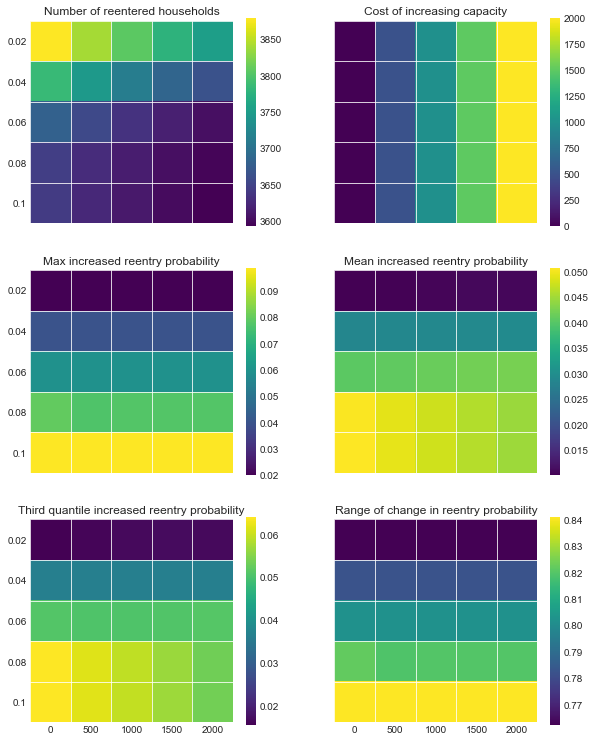

In [14]:
xlabels = th_search_space
ylabels = fairness_constraint_search_space

f, ax = plt.subplots(3, 2, figsize=(10, 13), sharex=True, sharey=True)

# Utility and cost in the first row
m = ax[0][0].imshow(percentage_reductions, cmap='viridis')
f.colorbar(m, ax=ax[0][0])
ax[0][0].set_title('Number of reentered households')

m = ax[0][1].imshow(capacity_costs, cmap='viridis')
f.colorbar(m, ax=ax[0][1])
ax[0][1].set_title('Cost of increasing capacity')

# Second and third rows contain fairness metrics
m = ax[1][0].imshow(max_prob_diff, cmap='viridis')
f.colorbar(m, ax=ax[1][0])
ax[1][0].set_title('Max increased reentry probability')

m = ax[1][1].imshow(avg_pos_prob_increase, cmap='viridis')
f.colorbar(m, ax=ax[1][1])
ax[1][1].set_title('Mean increased reentry probability')

m = ax[2][0].imshow(thirdq_pos_prob_increase, cmap='viridis')
f.colorbar(m, ax=ax[2][0])
ax[2][0].set_title('Third quantile increased reentry probability')

m = ax[2][1].imshow(range_prob_diff, cmap='viridis')
f.colorbar(m, ax=ax[2][1])
ax[2][1].set_title('Range of change in reentry probability')

ax[0][0].set_yticks([i for i in range(increase_budget)])
ax[0][0].set_yticklabels(ylabels)
ax[1][0].set_yticks([i for i in range(increase_budget)])
ax[1][0].set_yticklabels(ylabels)
ax[2][0].set_yticks([i for i in range(increase_budget)])
ax[2][0].set_yticklabels(ylabels)

ax[2][0].set_xticks([i for i in range(constraint_budget)])
ax[2][0].set_xticklabels(xlabels)
ax[2][1].set_xticks([i for i in range(constraint_budget)])
ax[2][1].set_xticklabels(xlabels)

for row in range(3):
    for col in range(2):
        ax[row][col].set_xticks(
            [i - 0.5 for i in range(constraint_budget + 1)], 
            minor=True
        )
        ax[row][col].set_yticks(
            [i - 0.5 for i in range(increase_budget + 1)], 
            minor=True
        )
        ax[row][col].grid(b=None)
        ax[row][col].grid(which='minor')

plt.show()

# Distance from individual best as a fairnessmetric

In [2]:
prob_df = pd.read_csv('../../data/data.csv', index_col=0)
capacity_df = prob_df['Real'].value_counts()

TYPES = ['ES', 'PSH', 'TH', 'RRH', 'PREV']


# All objective functions
def obj_f(x):
    fairness_constraint = x[0]
    
    helper = quan_utils.AssignmentHelper()
    
    new_capacity_df = capacity_df.copy()
    for type_index, type_ in enumerate(TYPES):
        new_capacity_df.loc[type_index + 1] += x[type_index + 1]
    
    helper.update_constraints(
        fairness_constraint=fairness_constraint,
        capacity_df=new_capacity_df
    )
    
    sol_df = helper.ip_solve()
    real_n_reentries, bart_n_reentries, sol_n_reentries = helper.compare_reentry(sol_df, verbose=False)
    prob_compare_df = helper.compare_prob(sol_df)
    
    return (
        sol_n_reentries,
        prob_compare_df[prob_compare_df['Diff'] > 0]['Diff'].quantile(0.75),
        prob_compare_df[prob_compare_df['Dist_from_best'] > 0]['Dist_from_best'].quantile(0.75)
    )

In [7]:
increase_budget = 6
constraint_budget = 6

th_search_space = [0, 1000, 2000, 3000, 4000, 5000]
fairness_constraint_search_space = [0, 0.02, 0.04, 0.06, 0.08, 0.1]

xs = [[[fairness_constraint, 0, 0, th_val, 0, 0]
        for th_val in th_search_space]
       for fairness_constraint in fairness_constraint_search_space]

xs

[[[0, 0, 0, 0, 0, 0],
  [0, 0, 0, 1000, 0, 0],
  [0, 0, 0, 2000, 0, 0],
  [0, 0, 0, 3000, 0, 0],
  [0, 0, 0, 4000, 0, 0],
  [0, 0, 0, 5000, 0, 0]],
 [[0.02, 0, 0, 0, 0, 0],
  [0.02, 0, 0, 1000, 0, 0],
  [0.02, 0, 0, 2000, 0, 0],
  [0.02, 0, 0, 3000, 0, 0],
  [0.02, 0, 0, 4000, 0, 0],
  [0.02, 0, 0, 5000, 0, 0]],
 [[0.04, 0, 0, 0, 0, 0],
  [0.04, 0, 0, 1000, 0, 0],
  [0.04, 0, 0, 2000, 0, 0],
  [0.04, 0, 0, 3000, 0, 0],
  [0.04, 0, 0, 4000, 0, 0],
  [0.04, 0, 0, 5000, 0, 0]],
 [[0.06, 0, 0, 0, 0, 0],
  [0.06, 0, 0, 1000, 0, 0],
  [0.06, 0, 0, 2000, 0, 0],
  [0.06, 0, 0, 3000, 0, 0],
  [0.06, 0, 0, 4000, 0, 0],
  [0.06, 0, 0, 5000, 0, 0]],
 [[0.08, 0, 0, 0, 0, 0],
  [0.08, 0, 0, 1000, 0, 0],
  [0.08, 0, 0, 2000, 0, 0],
  [0.08, 0, 0, 3000, 0, 0],
  [0.08, 0, 0, 4000, 0, 0],
  [0.08, 0, 0, 5000, 0, 0]],
 [[0.1, 0, 0, 0, 0, 0],
  [0.1, 0, 0, 1000, 0, 0],
  [0.1, 0, 0, 2000, 0, 0],
  [0.1, 0, 0, 3000, 0, 0],
  [0.1, 0, 0, 4000, 0, 0],
  [0.1, 0, 0, 5000, 0, 0]]]

In [8]:
percentage_reductions = []
thirdq_pos_prob_increase = []
thirdq_pos_dist_from_best = []

for i in range(constraint_budget):
    print(i)
    
    percentage_reductions.append([])
    thirdq_pos_prob_increase.append([])
    thirdq_pos_dist_from_best.append([])
    
    for j in range(increase_budget):
        result = obj_f(xs[i][j])
        
        percentage_reductions[-1].append(result[0])
        thirdq_pos_prob_increase[-1].append(result[1])
        thirdq_pos_dist_from_best[-1].append(result[2])

0
1
2
3
4
5


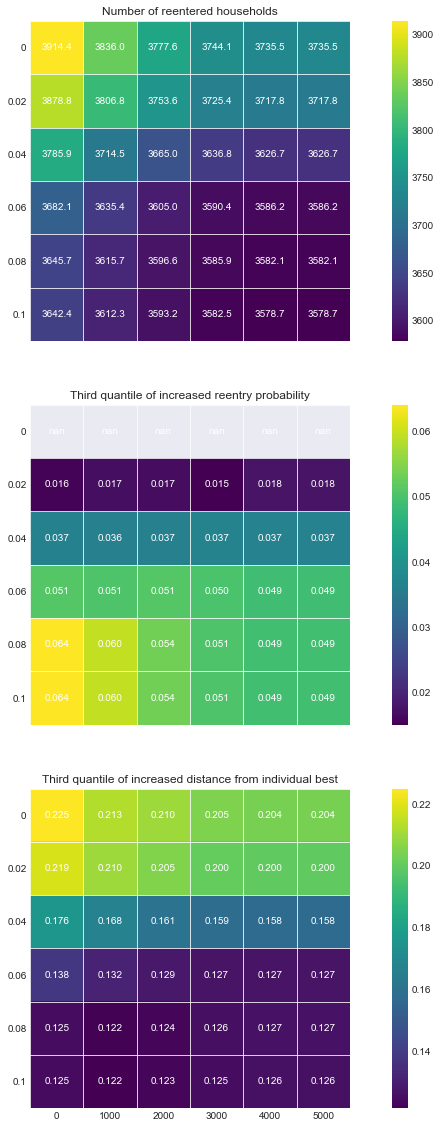

In [9]:
xlabels = th_search_space
ylabels = fairness_constraint_search_space

f, ax = plt.subplots(3, 1, figsize=(15, 20), sharex=True, sharey=True)

# Utility in the first row
m = ax[0].imshow(percentage_reductions, cmap='viridis')
f.colorbar(m, ax=ax[0])
ax[0].set_title('Number of reentered households')
for i in range(increase_budget):
    for j in range(constraint_budget):
        ax[0].text(i, j, f'{percentage_reductions[j][i]:.1f}', ha='center', va='center', color='w')

# Third quantile for increased probabilities in second row
m = ax[1].imshow(thirdq_pos_prob_increase, cmap='viridis')
f.colorbar(m, ax=ax[1])
ax[1].set_title('Third quantile of increased reentry probability')
for i in range(increase_budget):
    for j in range(constraint_budget):
        ax[1].text(i, j, f'{thirdq_pos_prob_increase[j][i]:.3f}', ha='center', va='center', color='w')

# Third quantile for increased distance from individual best
m = ax[2].imshow(thirdq_pos_dist_from_best, cmap='viridis')
f.colorbar(m, ax=ax[2])
ax[2].set_title('Third quantile of increased distance from individual best')
for i in range(increase_budget):
    for j in range(constraint_budget):
        ax[2].text(i, j, f'{thirdq_pos_dist_from_best[j][i]:.3f}', ha='center', va='center', color='w')

ax[0].set_yticks([i for i in range(constraint_budget)])
ax[0].set_yticklabels(ylabels)
ax[1].set_yticks([i for i in range(constraint_budget)])
ax[1].set_yticklabels(ylabels)
ax[2].set_yticks([i for i in range(constraint_budget)])
ax[2].set_yticklabels(ylabels)

ax[2].set_xticks([i for i in range(increase_budget)])
ax[2].set_xticklabels(xlabels)

for row in range(3):
    ax[row].set_xticks(
        [i - 0.5 for i in range(increase_budget + 1)], 
        minor=True
    )
    ax[row].set_yticks(
        [i - 0.5 for i in range(constraint_budget + 1)], 
        minor=True
    )
    ax[row].grid(b=None)
    ax[row].grid(which='minor')

plt.show()

# Histogram visualizations

In [2]:
prob_df = pd.read_csv('../../data/data.csv', index_col=0)
capacity_df = prob_df['Real'].value_counts()

TYPES = ['ES', 'PSH', 'TH', 'RRH', 'PREV']


# All objective functions
def obj_f(x):
    fairness_constraint = x[0]
    
    helper = quan_utils.AssignmentHelper()
    
    new_capacity_df = capacity_df.copy()
    for type_index, type_ in enumerate(TYPES):
        new_capacity_df.loc[type_index + 1] += x[type_index + 1]
    
    helper.update_constraints(
        fairness_constraint=fairness_constraint,
        capacity_df=new_capacity_df
    )
    
    sol_df = helper.ip_solve()
    if pulp.LpStatus[helper.prob.status] != 'Optimal':
        print(pulp.LpStatus[helper.prob.status])
    
    real_n_reentries, bart_n_reentries, sol_n_reentries = helper.compare_reentry(sol_df, verbose=False)
    prob_compare_df = helper.compare_prob(sol_df)
    
    return (
        (real_n_reentries - sol_n_reentries) / real_n_reentries * 100,
        prob_compare_df
    )

In [3]:
increase_budget = 4
constraint_budget = 4

th_search_space = [0, 500, 1000, 1500]
fairness_constraint_search_space = [0, 0.05, 0.1, 0.15]

xs = [[[fairness_constraint, 0, 0, th_val, 0, 0]
        for th_val in th_search_space]
       for fairness_constraint in fairness_constraint_search_space]

xs

[[[0, 0, 0, 0, 0, 0],
  [0, 0, 0, 500, 0, 0],
  [0, 0, 0, 1000, 0, 0],
  [0, 0, 0, 1500, 0, 0]],
 [[0.05, 0, 0, 0, 0, 0],
  [0.05, 0, 0, 500, 0, 0],
  [0.05, 0, 0, 1000, 0, 0],
  [0.05, 0, 0, 1500, 0, 0]],
 [[0.1, 0, 0, 0, 0, 0],
  [0.1, 0, 0, 500, 0, 0],
  [0.1, 0, 0, 1000, 0, 0],
  [0.1, 0, 0, 1500, 0, 0]],
 [[0.15, 0, 0, 0, 0, 0],
  [0.15, 0, 0, 500, 0, 0],
  [0.15, 0, 0, 1000, 0, 0],
  [0.15, 0, 0, 1500, 0, 0]]]

In [4]:
perct_reductions = []
input_to_real = pd.DataFrame(columns=[
    f'{i}_{j}' for i in range(constraint_budget) for j in range(increase_budget)
])
input_to_best = pd.DataFrame(columns=[
    f'{i}_{j}' for i in range(constraint_budget) for j in range(increase_budget)
])

for i in range(constraint_budget):
    print(i)
    
    perct_reductions.append([])
    
    for j in range(increase_budget):
        perct_reduction, prob_compare_df = obj_f(xs[i][j])

        perct_reductions[-1].append(perct_reduction)
        input_to_real[f'{i}_{j}'] = prob_compare_df['Input_to_real']
        input_to_best[f'{i}_{j}'] = prob_compare_df['Input_to_best']

0
1
2
3


In [5]:
perct_reductions

[[4.104896598481362, 5.142878529397737, 6.025701548432601, 6.804245411293847],
 [8.574815287359408,
  9.400449928491525,
  10.106943655046932,
  10.694293637677985],
 [10.769507027364408,
  11.171018990789163,
  11.505571666707908,
  11.771608985350792],
 [10.88499334412091,
  11.286983877682824,
  11.622117848530543,
  11.888888117736842]]

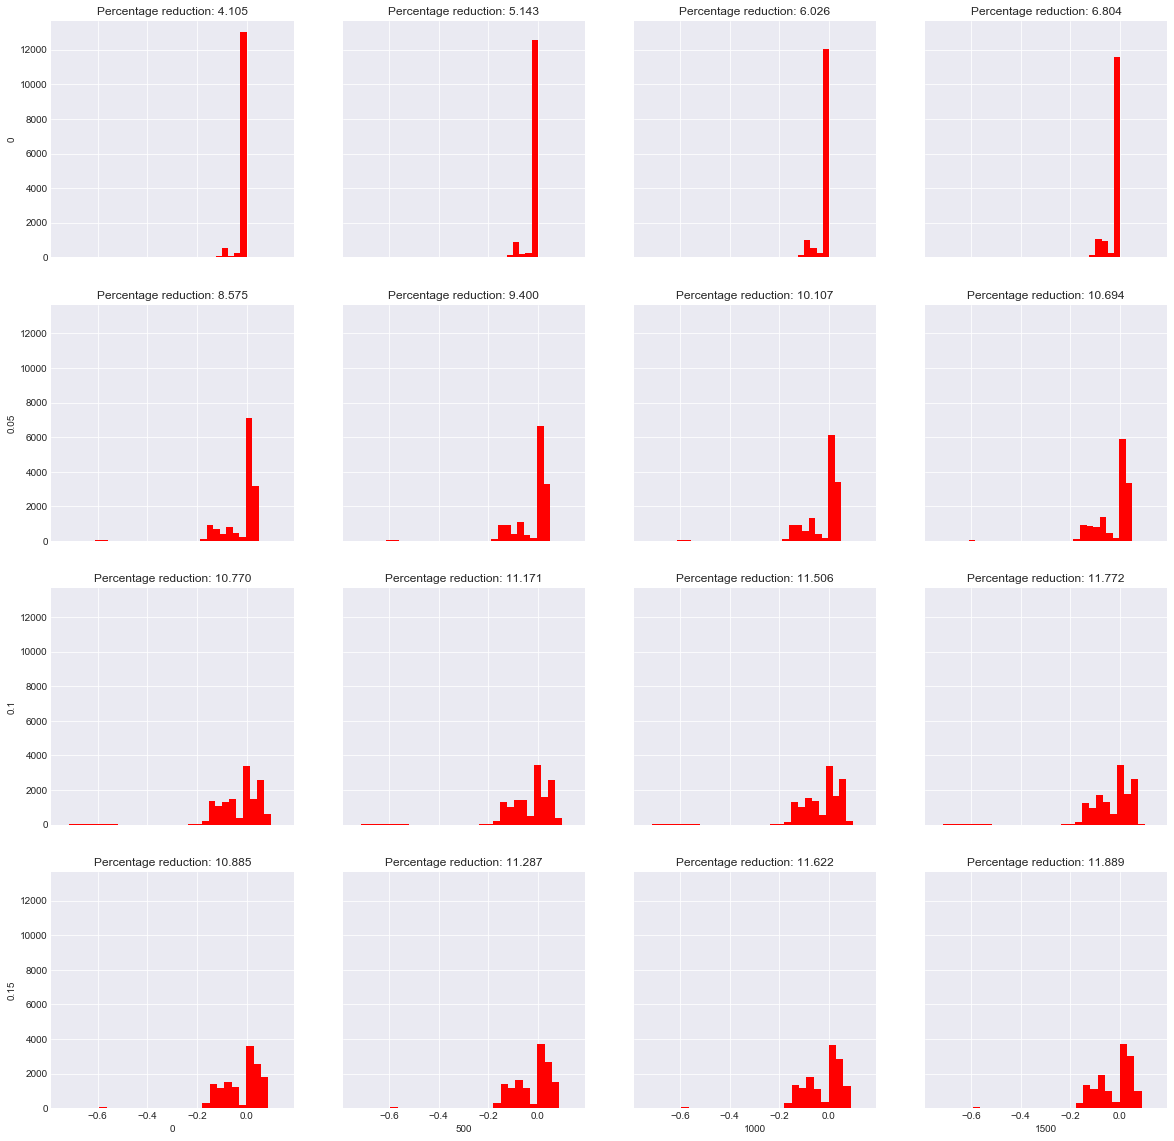

In [6]:
f, ax = plt.subplots(
    constraint_budget, increase_budget,
    figsize=(5 * constraint_budget, 5 * increase_budget),
    sharex=True, sharey=True
)

for i in range(constraint_budget):
    for j in range(increase_budget):
        ax[i][j].hist(
            input_to_real[f'{i}_{j}'], color='red', bins=30
        )
        
        ax[i][j].set_title(
            f'Percentage reduction: {perct_reductions[i][j]:.3f}')
        # ax[i][j].axvline(input_to_real[f'{i}_{j}'].mean(), c='red')
    
    ax[i][0].set_ylabel(fairness_constraint_search_space[i])
    
for j in range(increase_budget):
    ax[-1][j].set_xlabel(th_search_space[j])
    
plt.show()

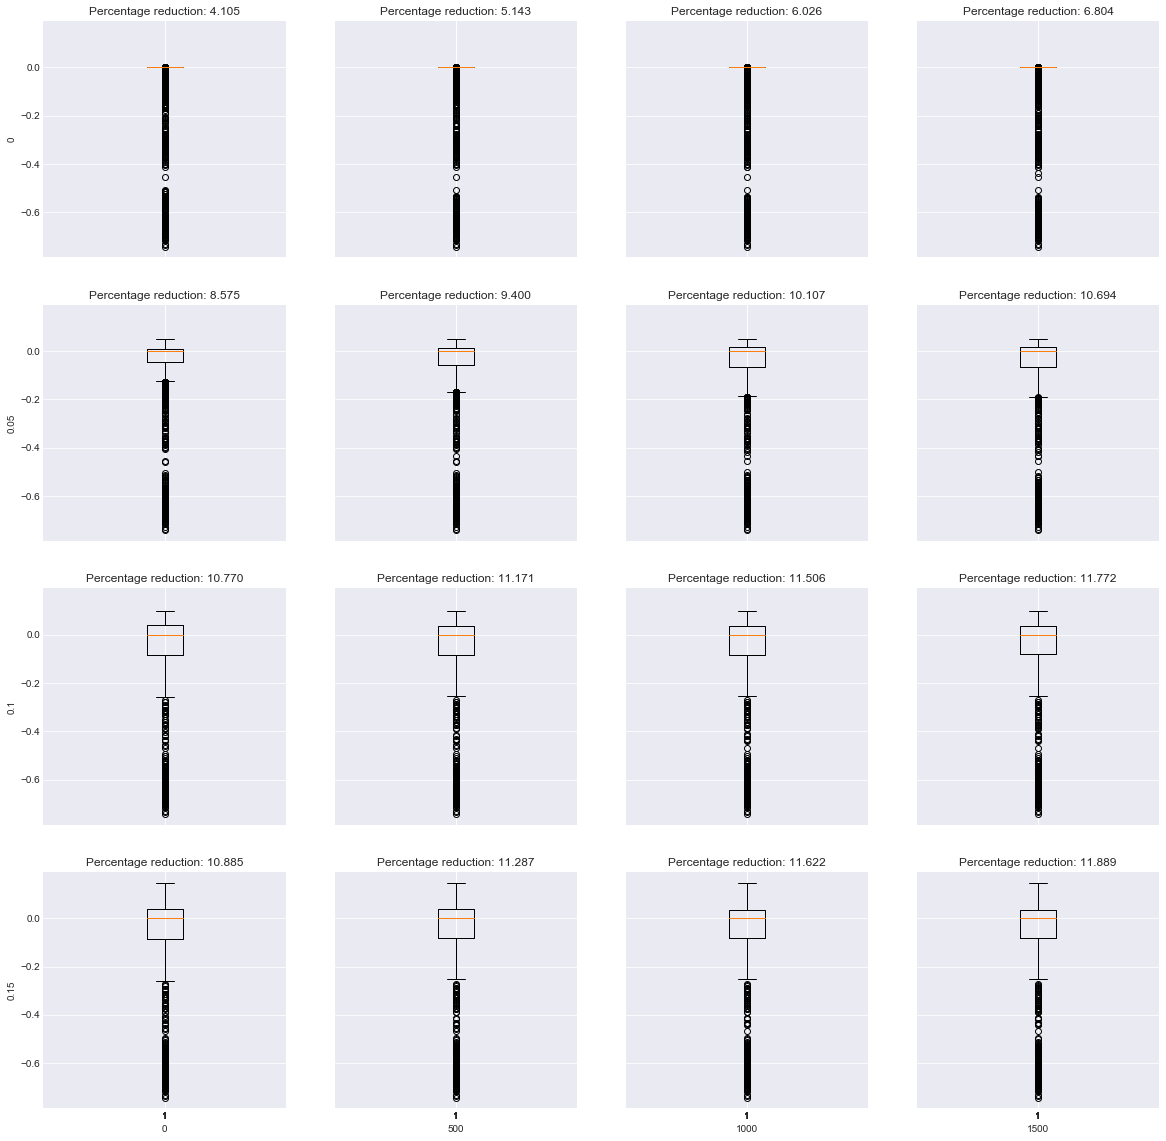

In [9]:
f, ax = plt.subplots(
    constraint_budget, increase_budget,
    figsize=(5 * constraint_budget, 5 * increase_budget),
    sharex=True, sharey=True
)

for i in range(constraint_budget):
    for j in range(increase_budget):
        ax[i][j].boxplot(
            input_to_real[f'{i}_{j}']
        )
        
        ax[i][j].set_title(
            f'Percentage reduction: {perct_reductions[i][j]:.3f}')
        # ax[i][j].axvline(input_to_real[f'{i}_{j}'].mean(), c='red')
    
    ax[i][0].set_ylabel(fairness_constraint_search_space[i])
    
for j in range(increase_budget):
    ax[-1][j].set_xlabel(th_search_space[j])
    
plt.show()

In [ ]:
# f, ax = plt.subplots(
#     constraint_budget, increase_budget,
#     figsize=(5 * constraint_budget, 5 * increase_budget),
#     sharex=True, sharey=True
# )

# for i in range(constraint_budget):
#     for j in range(increase_budget):
#         ax[i][j].boxplot(
#             input_to_real[f'{i}_{j}']
#         )
        
#         ax[i][j].set_title(
#             f'Percentage reduction: {perct_reductions[i][j]:.3f}')
#         # ax[i][j].axvline(input_to_real[f'{i}_{j}'].mean(), c='red')
    
#     ax[i][0].set_ylabel(fairness_constraint_search_space[i])
    
# for j in range(increase_budget):
#     ax[-1][j].set_xlabel(th_search_space[j])
    
# plt.show()

f, ax = plt.subplots(
    constraint_budget, increase_budget,
    figsize=(5 * constraint_budget, 5 * increase_budget),
    sharex=True, sharey=True
)



ax.imshow()

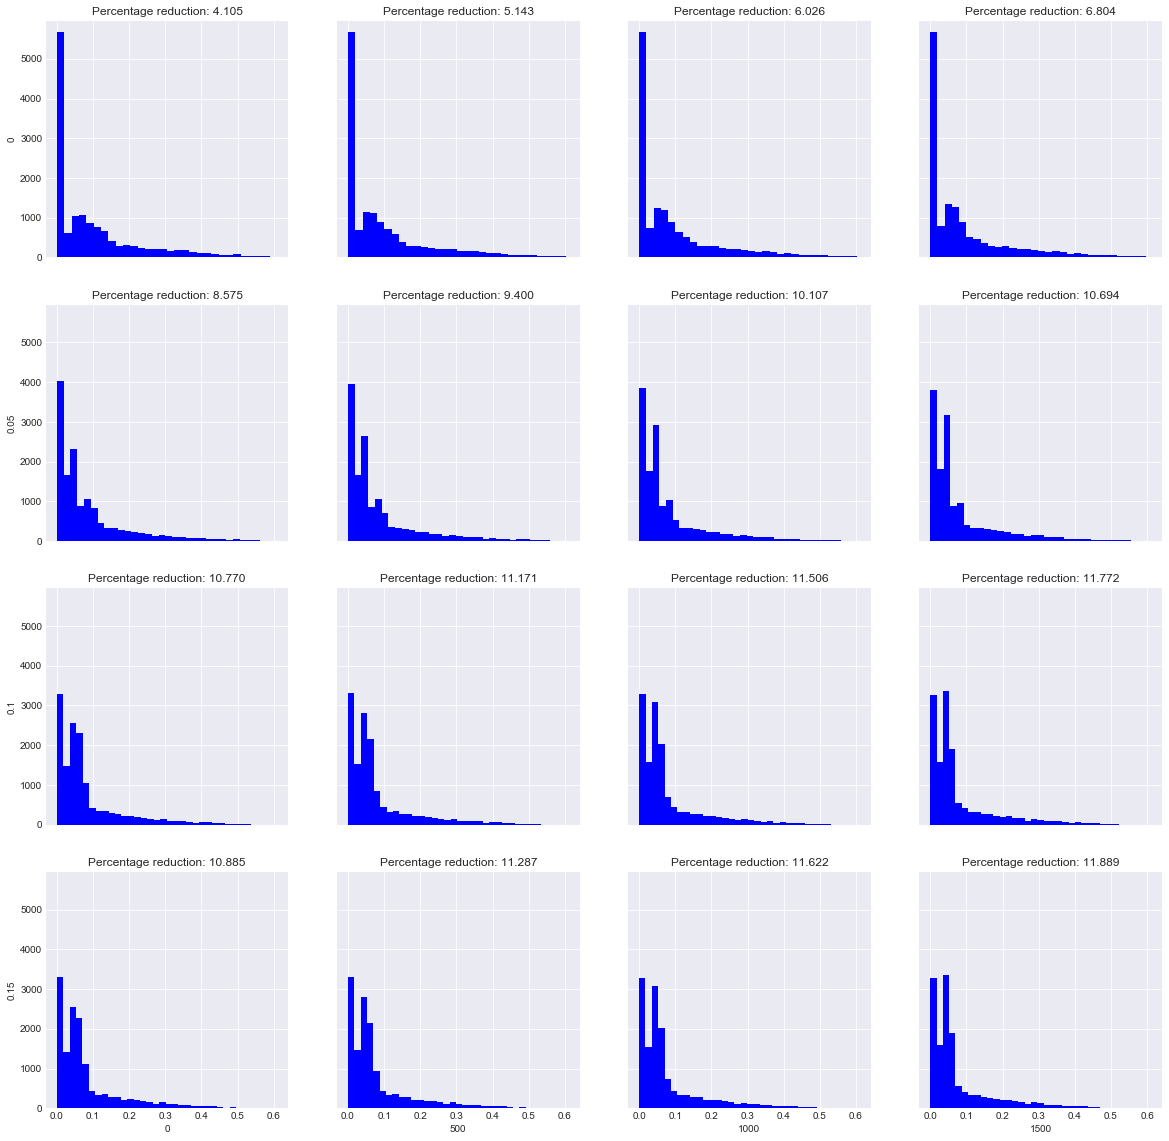

In [7]:
f, ax = plt.subplots(
    constraint_budget, increase_budget,
    figsize=(5 * constraint_budget, 5 * increase_budget),
    sharex=True, sharey=True
)

for i in range(constraint_budget):
    for j in range(increase_budget):
        ax[i][j].hist(
            input_to_best[f'{i}_{j}'], color='blue', bins=30
        )
        
        ax[i][j].set_title(
            f'Percentage reduction: {perct_reductions[i][j]:.3f}')
        # ax[i][j].axvline(input_to_best[f'{i}_{j}'].mean(), c='blue')
    
    ax[i][0].set_ylabel(fairness_constraint_search_space[i])
    
for j in range(increase_budget):
    ax[-1][j].set_xlabel(th_search_space[j])
    
plt.show()

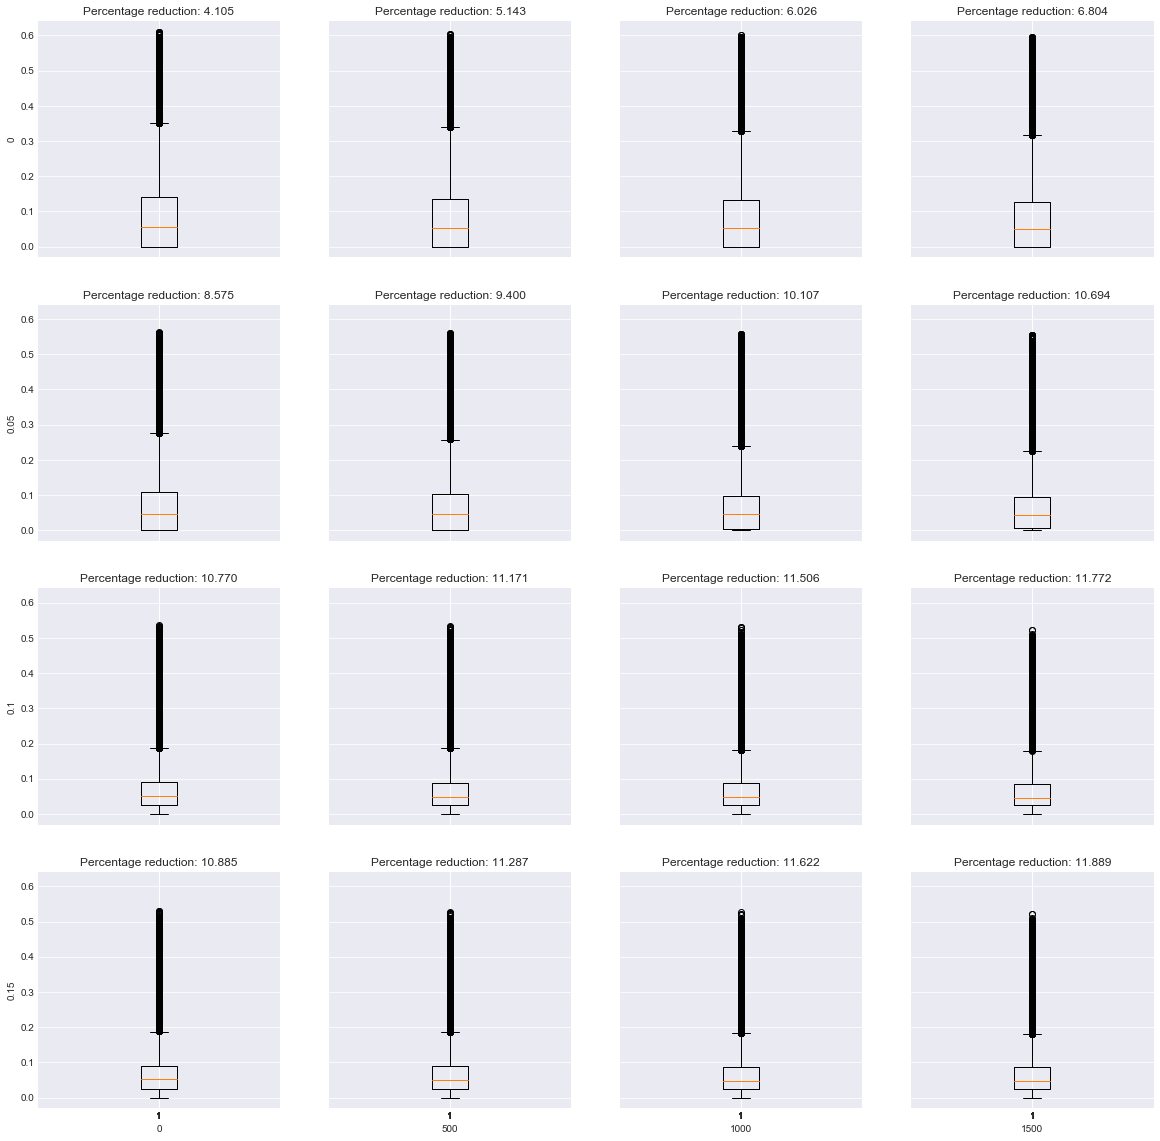

In [11]:
f, ax = plt.subplots(
    constraint_budget, increase_budget,
    figsize=(5 * constraint_budget, 5 * increase_budget),
    sharex=True, sharey=True
)

for i in range(constraint_budget):
    for j in range(increase_budget):
        ax[i][j].boxplot(
            input_to_best[f'{i}_{j}']
        )
        
        ax[i][j].set_title(
            f'Percentage reduction: {perct_reductions[i][j]:.3f}')
        # ax[i][j].axvline(input_to_best[f'{i}_{j}'].mean(), c='blue')
    
    ax[i][0].set_ylabel(fairness_constraint_search_space[i])
    
for j in range(increase_budget):
    ax[-1][j].set_xlabel(th_search_space[j])
    
plt.show()